In [119]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt 
from astropy.io import ascii 
from astropy.table import Table, Column, MaskedColumn





This will be what is part of the mark down I would implement with the sphinx, once I understand how to work it. 

This project includes spectrscopic observations taken at the DAO with the SITe-2 detector. For the purpose of  inspecting flux profiles of spectral lines gathered with various instruments, we have to use a the normalized spectrum. We do this by fitting the continuum. We segment the data into several bins containing 100 data point following their order in wavelength. We select the median flux within each bin, which allows us to reduce the weight of outlying data, such as points along emission, absoprtion lines, and instrumental noise. All polynomial fitting was conducted to 3rd order using built in numpy function.




In [120]:
### 45, 46, 47,  48, 61, 62, 63, 64, 83, 84, 85 

###This cell is intended to test individual DAO files, for purposes such as 
##reviewing the headers 
##it also allow for the use to know how information stored in the headers are 
## labeled
hdu = fits.open('dao_c182_2019_020585_v.fits')


###Loading in the data 
data = hdu[0].data

##assigning the headers to a variable. 
header1 = hdu[0].header

####neatly prints the headers. 
print(repr(header1))

#####one can call out puts of individual headers. 
#print(header['MJD-OBS']) 
#print(header['HJD'])

#print(Filename)

FileNotFoundError: [Errno 2] No such file or directory: 'dao_c182_2019_020585_v.fits'

In [ ]:
####General information about the structure of the fits file
hdu.info()

## dao_normal is the primary function for continuum normalization specifically for data acquired at the DAO. This can be modified to normalize other full spectra. 

In [121]:
####this function will normalize spectrum from the DAO. 
#### this function requires two inputs the array containing the fluxes
##(flux_dao) and one containing the wavelenght(lambda_dao) 

def dao_normal(wave_len, flux,  final_plt=False, bin_wid=100, fit_order=3):
    
    """ The input for this function needs to be numpy arrays for wavelength (wave_len) and flux.
    
    :param  wave_len: numpy arrays for wavelength (wave_len).    
    :param  flux: numpy arrays for flux.
    :param  bin_wid: The width of the bins is set by bin_wid, which need to be an integer. 
    :param  fit_order: Integer: The order for the polynomial fitting
    """  
    
    
    ####these are empty array in which we will store the median fluxes and wavelengths of each bin 
    
    
    array_size = flux.size  
    
    ##n_bins (integer) is the total number of bins that fit in the array 
    n_bins = array_size // bin_wid 
    
    flux_med = np.zeros(n_bins)
    wave_med = np.zeros(n_bins)
    ###binning and finding the median flux and wavelength each bin. 
    ### iterations and bin size a set by the indices in the inputed arrays. 
    
    
    for i in range(0, n_bins): 
        ###the index upper boundary for a each successive bin. 
        ### The upper and lower boundary for each bin account for the counting initalizing at 0
        n = i * bin_wid  + (bin_wid - 1 ) 
        
        ####the lower bound.
        n_low = i * bin_wid 
    
        ###breaking down each array into segments of the set bin size 
        data_seg = flux[n_low: n + 1] 
        wave_seg = wave_len[n_low: n + 1]
        
        ###extracts the median and stores it defined arrays outside the loop
        med =   np.median(data_seg) 
        flux_med[i] = med
    
        mid_wave = np.median(wave_seg) 
    
        wave_med[i] = mid_wave  
     
    #### polynomial fitting of the median fluxes with respect to the median wavelenths 
    ### the integer at the end of the function idicates the order of the polynomial fit . 
    ### Refer to numpy documentation on these functions as needed. 
    con_fit = np.poly1d(np.polyfit(wave_med, flux_med , fit_order))   
    
    ##the final normalization of the spectrum to the median-derived continuum fit.
    normed_spec = flux / con_fit(wave_len)
    
    if final_plt==True:
        wave_fit = np.linspace(min(wave_len), max(wave_len),2000)
    
        fig, ((ax1), (ax2)) = plt.subplots(2,1, figsize=(10,12))  
        ax1.plot(wave_len, flux, zorder=0)
        ax1.scatter(wave_med, flux_med, color='r', linewidths='5.0', zorder=2)
        ax1.plot(wave_fit, con_fit(wave_fit), color='k', linewidth='2.5')
        ax1.set_ylabel('flux ')
    
        ax2.plot(wave_len, normed_spec)
        ax2.set_xlabel('wavelength (Angstroms)')
        ax2.set_ylabel('normalized flux ')
    
    
     
    ### this function will return the normalized spectrum and the polynomial fits used.     
    if final_plt==True:
        return normed_spec, con_fit, fig, ((ax1), (ax2)) 
    else:
        return normed_spec, con_fit

In [ ]:
help(dao_normal)

In [ ]:
help(np.arange)

In [ ]:
####This of the two subsrcipts used to process and normalize the DAO data 


###this can be converted into a function if needed. For the purpose of this project the following 
## script was the faster approach. 

#### the list of the last two unique digits on the set of files used 
end_tele = ([45, 46, 47,  48, 61, 62, 63, 64, 83, 84, 85])

#hjds = np.zeros(np.size(end_tele)) 

dao_name = [] 

dao_fit = np.zeros((np.size(end_tele), 4))


for i in range (0, np.size(end_tele)): 
    
    #print(str(i) + ' dao') 
    
    ###loading in the fits file. 
    ##.fits is what goes in, and .dat will be the output with similar name. 
    
    hdu = fits.open('../DAOdata/dao_c182_2019_0205' + str(end_tele[i]) +'_v.fits') 
    dao_data = hdu[0].data
    dao_header1 = hdu[0].header  
    
    dao_name.append('dao_c182_2019_0205' + str(end_tele[i]) +'_v.dat') 
    hjds[i] = dao_header1['HJD']
    
    
    #total_rotation =  rot_phase(dao_header1['HJD']) 
    #dao_rot_num, dao_phase = rot_num_phase_sep(total_rotation) 
    
    
    ####building the wavelegnth array from the pixel information in the headers.
    pixel0 = dao_header1['CRPIX1']
    delta_w = dao_header1['CDELT1']
    w0 = dao_header1['CRVAL1']

    wave_dao = (w0 + np.arange(0,dao_data.size, 1)*delta_w ) /10.0  
    
    ### this is where the spectum is normalized by the continuum fit.
    dao_normed = dao_normal( dao_data,  wave_dao)
    
    ##### saving the fitting parameters 
    fit = dao_normed[1] 
    dao_fit[i, 0], dao_fit[i, 1], dao_fit[i, 2], dao_fit[i, 3]  = fit[3], fit[2], fit[1], fit[0] 
    
    
    ####storing the normalized flux
    dao_flux_normed = dao_normed[0]
    
    
    ### storing the wavelength and normalized flux in the output file
    
    #dao_data = Table([wave_dao, dao_flux_normed], names=['lambda', 'flux'])
    #ascii.write(dao_data, dao_name[i] ,overwrite=True)  

#plt.plot(wave_dao, dao_normed)    
#print(dao_fit)     




In [ ]:
print(hjds) 

In [ ]:
##### 2021 dao  data 

###Using header to get information on each individual file.

hdu = fits.open('January2021DAO/dao_c182_2021_000737_v.fits') 



data = hdu[0].data
header1 = hdu[0].header

print(repr(header1))

In [ ]:
end_tele = ([669, 670, 671, 672, 731, 732, 733,  734, 737, 738])
names = [] 
dates = []

hjds = np.zeros(np.size(end_tele))

for i in range (0, np.size(end_tele)): 
    
    hdu = fits.open('January2021DAO/dao_c182_2021_000' + str(end_tele[i]) +'_v.fits')
    hdu.info()
    header = hdu[0].header
        
    #hjds[i] =  header['HJD']
    
    names.append('dao_c182_2021_000' + str(end_tele[i]))

In [ ]:
#hjds

In [ ]:
#### This is a duplicate of the same process in cells above applied to first observations 
### collected in the winter-spring 2021 cycle 
end_tele = ([669, 670, 671, 672, 731, 732, 733,  734, 737, 738])

hjds = np.zeros(np.size(end_tele)) 
dao_name = [] 

dao_fit = np.zeros((np.size(end_tele), 4))


for i in range (0, np.size(end_tele)): 
    
    #print(str(i) + ' dao') 
    
    hdu = fits.open('January2021DAO/dao_c182_2021_000' + str(end_tele[i]) +'_v.fits') 
    dao_data = hdu[0].data
    dao_header1 = hdu[0].header  
    
    dao_name.append('dao_c182_2021_000' + str(end_tele[i]) +'_v.dat') 
    hjds[i] = dao_header1['HJD']
    
    
    #total_rotation =  rot_phase(dao_header1['HJD']) 
    #dao_rot_num, dao_phase = rot_num_phase_sep(total_rotation) 
    
    
    
    pixel0 = dao_header1['CRPIX1']
    delta_w = dao_header1['CDELT1']
    w0 = dao_header1['CRVAL1']

    wave_dao = (w0 + np.arange(0,dao_data.size, 1)*delta_w ) /10.0  
    
    dao_normed = dao_normal( dao_data,  wave_dao)
    fit = dao_normed[1] 
    dao_fit[i, 0], dao_fit[i, 1], dao_fit[i, 2], dao_fit[i, 3]  = fit[3], fit[2], fit[1], fit[0] 
    
    dao_flux_normed = dao_normed[0]
    
    #dao_data = Table([wave_dao, dao_flux_normed], names=['lambda', 'flux'])
    ascii.write(dao_data, dao_name[i] ,overwrite=True)  

#plt.plot(wave_dao, dao_normed)    
print(dao_fit) 

In [122]:
##### function to load  DAO 

###include rtype: what it will return

def load_dao(dao_filename):
    """
    This file is will load in the dao file ( or files like it). It will extrac the
    
    :param  filename: this needs to be inserted as string 
    
    """
    hdu_dao = fits.open(dao_filename) 
    flux_dao = hdu_dao[0].data
    
    header_dao = hdu_dao[0].header
    
    pixel0_dao = header_dao['CRPIX1']
    delta_w_dao = header_dao['CDELT1']
    w0_dao = header_dao['CRVAL1']

    wave_dao = w0_dao + np.arange(0,flux_dao.size, 1)*delta_w_dao 
    
    return wave_dao, flux_dao, header_dao

In [123]:
 
def dao_wrapper(file_name, name_mods="_norm_test", out_type=None, out_plot_type=None): 
    """file_name_manip: this function assumes that it following the typical format where the only period seprates the filename and type. eg(Path/file.type) 
    it assumes it will be written where it was read"""
    filename_dot_split = file_name.split(".") 
    file_name_slash_split = filename_dot_split[0].split("/")   
    modify_name = file_name_slash_split[-1] + name_mods
    
    recomb = file_name_slash_split[0:-1] 
    recomb.append(modify_name)
    file_out_name = '/'.join(recomb) + out_type
    plot_out_name = '/'.join(recomb) + out_plot_type 
    
    wave, orig_flux, file_header  = load_dao(file_name) 
    
    flux_norm, spec_fit, fig, ((ax1), (ax2))=  dao_normal(wave, orig_flux,  final_plt=True, bin_wid=100, fit_order=3)
    
    
    out_table = Table([wave, flux_norm], names=['lambda', 'flux'])
    ascii.write(out_table, file_out_name ,overwrite=True) 
    fig.savefig(plot_out_name)
    
    
    
    

    
    
    ###calling the file
    
    return None
    

In [ ]:
dao_wrapper('/Users/shaquannseadrow/Research_UD_2019/DAOdata/January2021DAO/dao_c182_2021_000670_v.fits', name_mods='_norm', out_type=".txt",
                                   out_plot_type='.jpeg' )

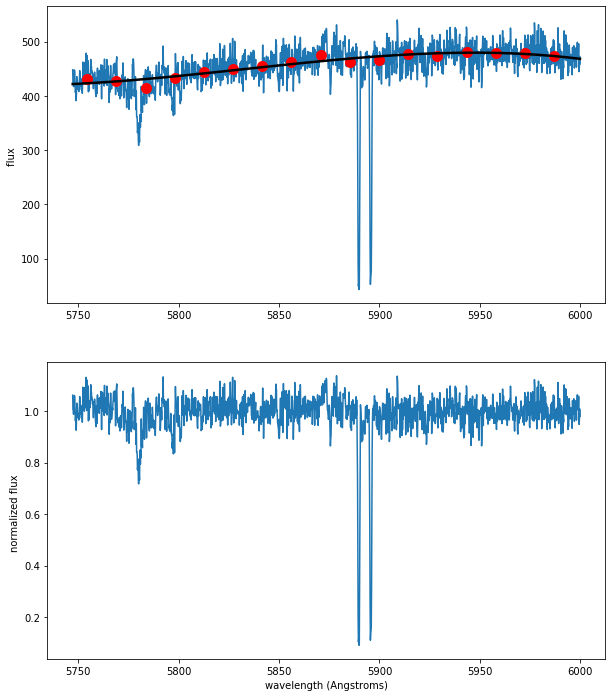

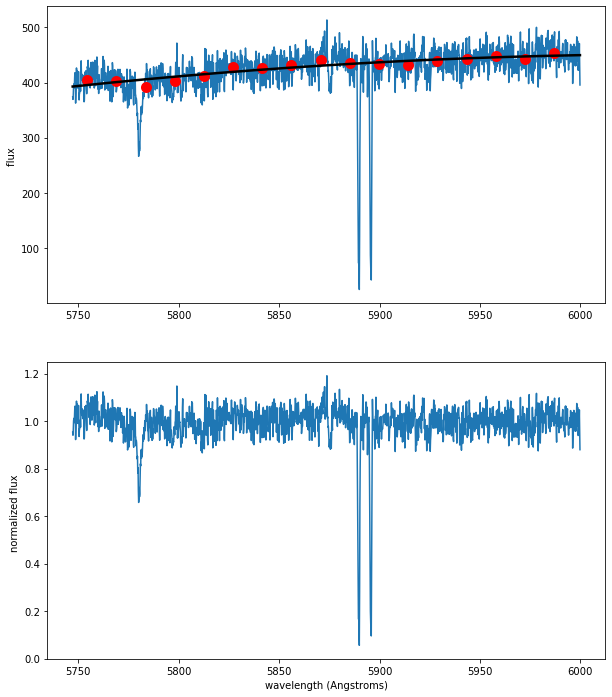

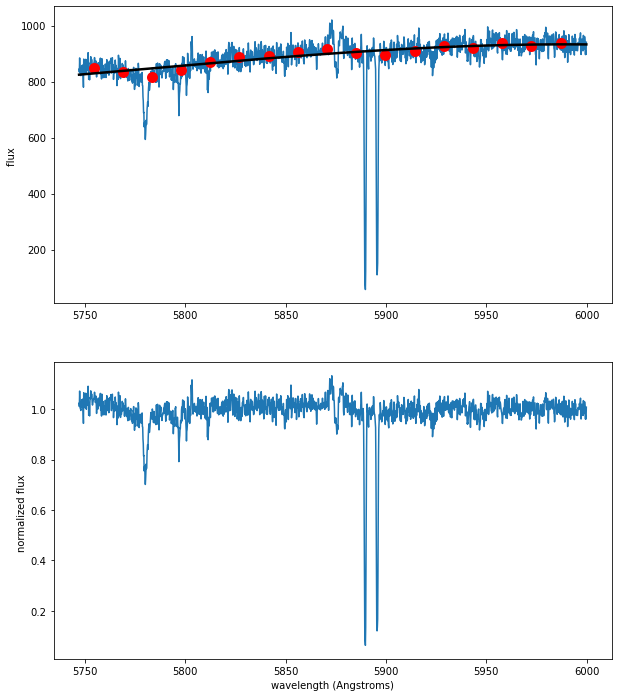

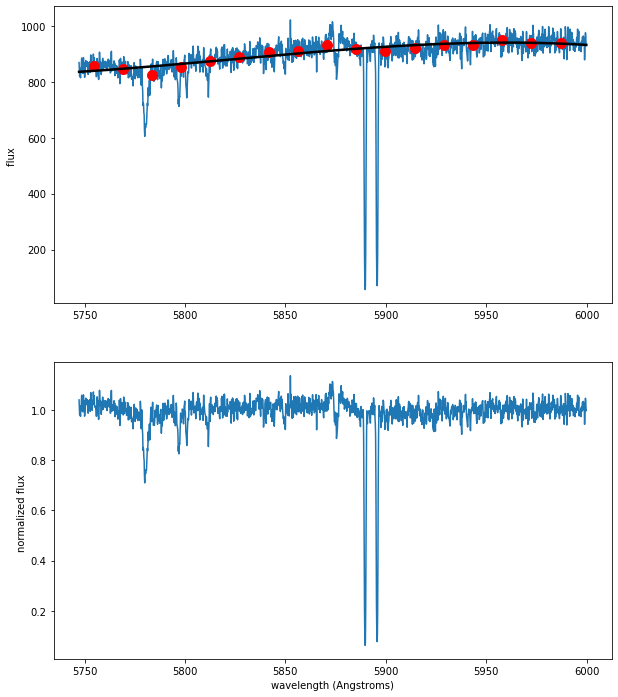

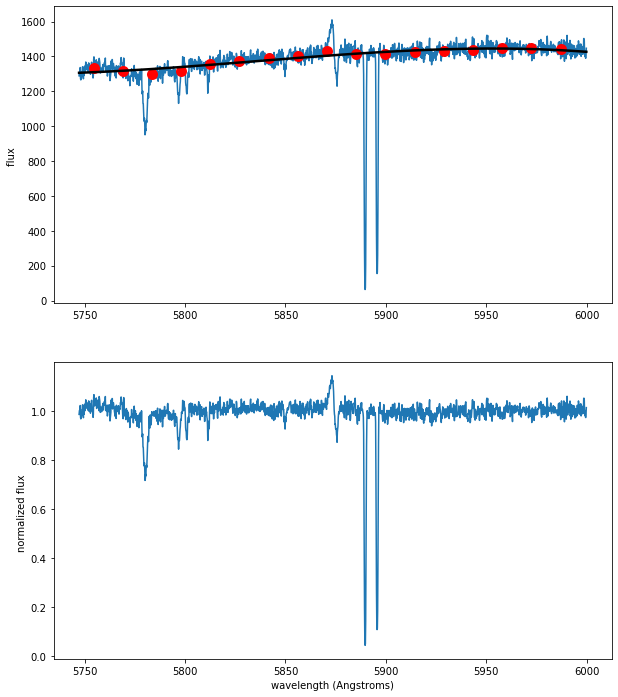

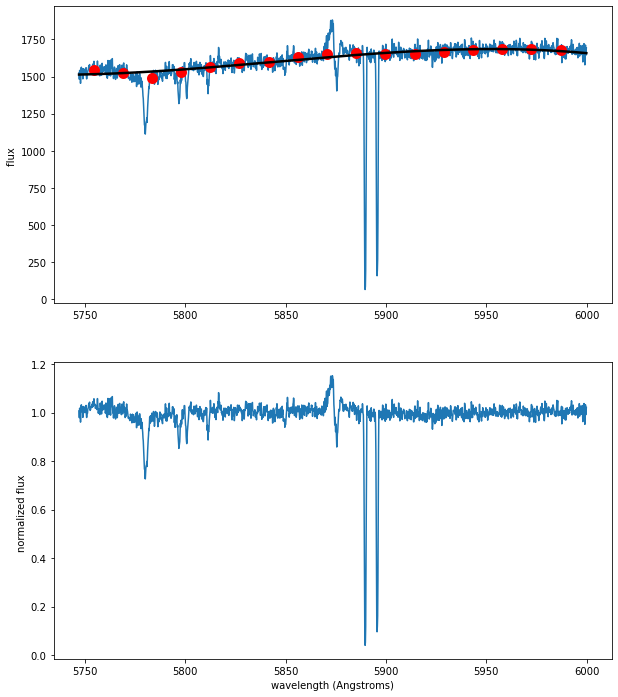

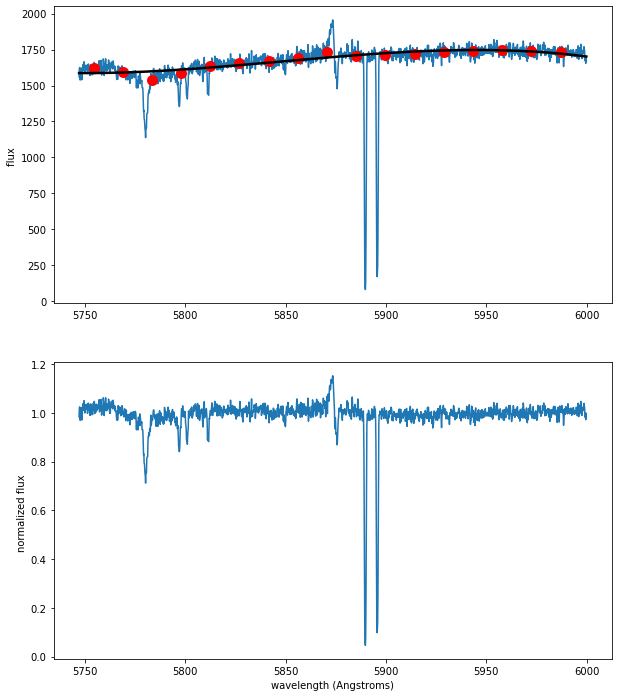

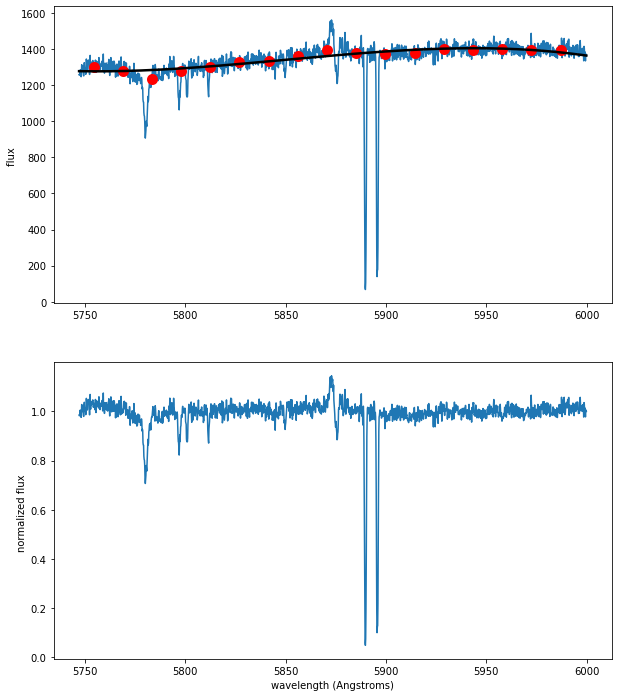

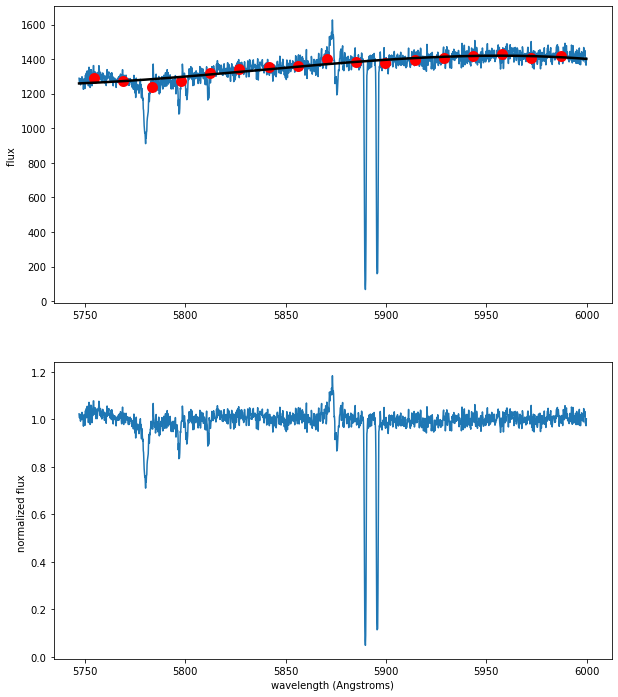

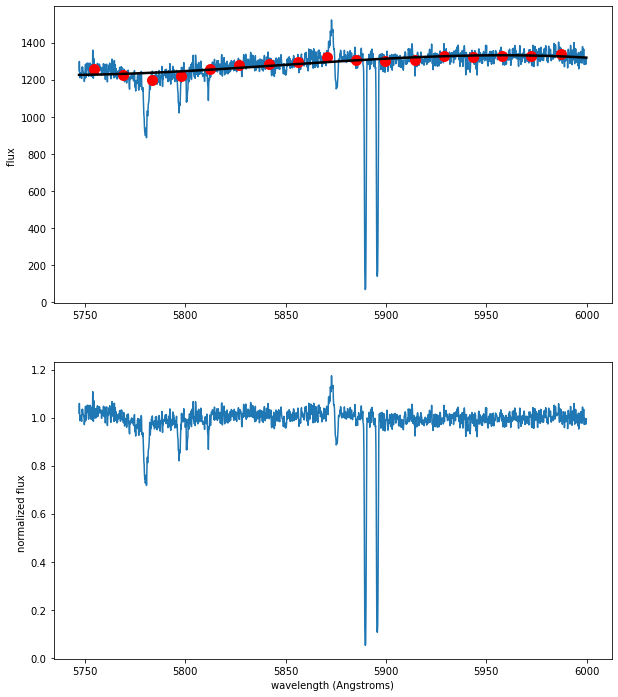

In [124]:
path_to_dir = '/Users/shaquannseadrow/Research_UD_2019/DAOdata/'

end_file_id = ([669, 670, 671, 672, 731, 732, 733,  734, 737, 738])

for i in range (0, np.size(end_file_id)): 
    
    
    dao_wrapper(path_to_dir + 'January2021DAO/dao_c182_2021_000' + str(end_file_id[i]) +'_v.fits', name_mods='_norm_test1', out_type=".txt",
                                   out_plot_type='.jpeg' ) 





## Below is demonstration ( with visual aide) of the normalization prodecures for the DAO data. This is the frame work the DAO_normalization function used above. 

In [ ]:
hdu_ex = fits.open('dao_c182_2019_020585_v.fits')

###Loading in the data 
data_ex = hdu_ex[0].data

##assigning the headers to a variable. 
header_ex = hdu_ex[0].header


In [ ]:
pixel0_ex = header_ex['CRPIX1']
delta_w_ex = header_ex ['CDELT1']
w0_ex = header_ex['CRVAL1']

wave_ex = w0_ex + np.arange(0,data_ex.size, 1)*delta_w_ex

hdu_ex.close()


print(data_ex.dtype)
print(data_ex.shape)

cfit_ex = np.poly1d(np.polyfit(wave_ex, data_ex , 3)) 

wave_ex_fine = np.linspace(min(wave_ex), max(wave_ex),2000) 




fig, ax = plt.subplots(1,1, figsize=(10,8))

ax.plot(wave_ex, data_ex)
ax.plot(wave_ex_fine, cfit_ex(wave_ex_fine), color='k', linewidth='2.5')
ax.set_xlabel('wavelength (Angstroms)')
ax.set_ylabel('flux ')

plt.show()  


In [ ]:
### binning and extracting the median flux (and correspoding wavelength) 
# in each bin  


####17 was decided based on the width of the bins and the number of 
# data points in the file.
flux_med_ex = np.zeros(17)
wave_med_ex = np.zeros(17)

### the itteration and segmentation of flux and wavelengths arrays are
# with respect to the indices of each array element.  
for i in range(0, 17): 
    n = i *100 + 99 
    n_low = i *100
    
    data_seg_ex = data_ex[n_low: n + 1] 
    wave_seg_ex = wave_ex[n_low: n + 1]
    med_ex =   np.median(data_seg_ex)
    #a = np.where(data_seg == med)
    print(np.median(data_seg_ex)) 
    #print(np.median(wave_seg_ex)) 
    
    #print(np.max(data_seg), np.min(data_seg))
    #print(a[0])
    flux_med_ex[i] = med_ex
    
    mid_wave_ex = np.median(wave_seg_ex) 
    
    wave_med_ex[i] = mid_wave_ex 
    


In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,8))


ax.plot(wave_ex, data_ex, zorder=0)


ax.plot(wave_ex_fine, cfit_ex(wave_ex_fine), color='k', linewidth='2.5',)
ax.scatter(wave_med_ex, flux_med_ex, color='r', linewidths='5.0', zorder=2)
#ax.plot(wave_med, flux_med, color='r', linewidth='2.5')
ax.set_xlabel('wavelength (Angstroms)')
ax.set_ylabel('flux ')


plt.show()  


In [ ]:
####fitting using the bin medians
cmed_fit_ex = np.polyfit(wave_med_ex, flux_med_ex , 3)
cfit2_ex = np.poly1d(cmed_fit_ex) 




In [ ]:
print(cfit2_ex)

In [ ]:
###making a finer delta_lambda for the wavelegnth array.
wave_ex_fine2 = np.linspace(min(wave_med_ex), max(wave_med_ex),2000) 

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,8))

ax.plot(wave_ex, data_ex, zorder=0)
#ax.plot(wave_fine, p(wave_fine), color='k', linewidth='1.5',) 
ax.plot(wave_ex, cfit2_ex(wave_ex), color='r', linewidth= 2.5 )
#ax.scatter(wave_med, flux_med, color='r', linewidths='5.0', zorder=2)
#ax.plot(wave_fine_2, p2(wave_fine_2), color='r', linewidth='2.5')
ax.set_xlabel('wavelength (Angstroms)')
ax.set_ylabel('flux ')

plt.show()  

In [ ]:
flux_normed_ex = data_ex / cfit2_ex(wave_ex)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,8))
ax.plot(wave_ex, flux_normed_ex, zorder=0)
ax.set_xlabel('wavelength (Angstroms)')
ax.set_ylabel('normalized flux ')

Above is an an example of a normalized spectrum that we use to calculate the equivalent widths.